In [190]:
import warnings
import json

import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns

from jre_utils.process import get_most_active_municipalities
from jre_utils.datapath import model_ready_data_paths, DATA_DIRECTORY_PATH

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [191]:
asset_type = "combined"
dataset_key = "transactions"
years_ahead = 4

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

# granularity_columns = ["area", "area_code"]
granularity_columns = ["area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "ols"
metric = metrics[metric_key]
metric_sharpe = metric + "_sharpe"

In [192]:
investment_asset_type = "building"


In [193]:
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

In [194]:
core_df = pd.read_csv(model_ready_data_path)
core_df["area_code"] = core_df["area_code"].astype(str)
core_df["noise"] = np.random.normal(0, 1, core_df.shape[0])


In [195]:
core_df.columns

Index(['area', 'area_code', 'year', 'building_count_log_normalized_yearly',
       'building_yearly_price_growth_log_normalized_yearly',
       'building_ols_price_index_sharpe', 'building_ols_price_index',
       'building_metric_sharpe_is_available',
       'building_ols_price_index_sharpe_normalized_yearly', 'building_count',
       'building_yearly_price_growth', 'land_count_log_normalized_yearly',
       'land_yearly_price_growth_log_normalized_yearly',
       'land_ols_price_index_sharpe', 'land_ols_price_index',
       'land_metric_sharpe_is_available',
       'land_ols_price_index_sharpe_normalized_yearly', 'land_count',
       'land_yearly_price_growth', 'condo_count_log_normalized_yearly',
       'condo_yearly_price_growth_log_normalized_yearly',
       'condo_ols_price_index_sharpe', 'condo_ols_price_index',
       'condo_metric_sharpe_is_available',
       'condo_ols_price_index_sharpe_normalized_yearly', 'condo_count',
       'condo_yearly_price_growth', 'population', 'pop

In [196]:
from jre_utils.process import get_cumulative_growth
from jre_utils.visualize import plot_time_series


area_codes = ["13103", "1100", "12238"]
area_df = core_df[core_df["area_code"].isin(area_codes)].sort_values(by="year", ascending=True)

color_map = {
    "13103": "#03045e",
    "1100": "#0077b6",
    "12238": "#00b4d8",
}

plot_time_series(
    area_df,
    f"{investment_asset_type}_{metric}",
    group_by_columns,
    granularity_columns,
    f"Price Index over time",
    # visible="legendonly",
    width=1000,
    height=600,
    # highlight=True,
    # highlight_range=(2020, 2022)
    color_discrete_map=color_map
)


In [197]:
columns = [
    "area_code",
    "year",
    f"{investment_asset_type}_{metric}",
    "population",
    "taxable_income",
    "existing_dwellings",
]

df = core_df[columns]
df

,area_code,year,building_ols_price_index,population,taxable_income,existing_dwellings
0,23441,2008,100.000000,25136.592636,41348658.0,NaN
1,23441,2009,77.351727,25374.112910,40698843.0,NaN
2,23441,2010,85.372440,25695.000000,37069636.0,NaN
3,23441,2011,75.213546,26248.000000,37957523.0,NaN
4,23441,2012,77.844830,26793.000000,39195622.0,NaN
...,...,...,...,...,...,...
19264,19424,2022,NaN,9285.000000,NaN,NaN
19265,19384,2007,NaN,20361.000000,26513666.0,NaN
19266,28206,2007,NaN,92697.000000,259307366.0,41057.0
19267,47211,2007,NaN,145554.000000,111372337.0,45992.0


In [198]:
# Notes from Professor Webster

# I can suggest that you to try something a bit different with the data. Can you fit the following power-law growth model (log-log transform and simple regression).
 
# Yi = Y0 * P^β * e
 
# Regress:
# Log Yi = log Y0 + P*β + e
 
# Where Yi=Price index for city i
# P=population of city i, (including base pop plus net migration)
# β=growth coefficient to be determined
# Y0=constant
# e=error term
# (Add subscript t to all terms for the time-series version)
 
# Modelling options:
# First fit the model cross-sectionally, say at T0 and Tn (first and last year in your time series)
# Second fit with your compete time series data
# Third, fit either cross-sectional or time-series, for different types of cities. For example, classifying your cities into quintiles based on GDP.

In [199]:
# The above model would work only if it's for individual cities.
# For the whole country, we need to use a slightly modified model.

# Yit = Yi0 * (Pit/Pi0)^β * e

# Yit = price index for city i at time t
# Yi0 = price index for city i at time 0
# Pit = population for city i at time t
# Pi0 = population for city i at time 0
# β = growth coefficient
# e = error term

In [200]:
x = "population"
y = f"{investment_asset_type}_{metric}"

area_code = "13102"

area_df = df[df["area_code"] == area_code].reset_index(drop=True)
area_df = area_df[~area_df[x].isna()].reset_index(drop=True)

area_df["x"] = np.log(area_df[x])
area_df["y"] = np.log(area_df[y])
area_df["C"] = np.log(area_df[y][0])

model = sm.OLS(area_df["y"], sm.add_constant(area_df[["x", "C"]])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     27.27
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           0.000103
Time:                        15:40:55   Log-Likelihood:                 4.4304
No. Observations:                  17   AIC:                            -4.861
Df Residuals:                      15   BIC:                            -3.194
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.1593      0.413      5.222      0.000       1.278       3.041
C             -4.5173      1.067     -4.234      0.001      -6.791      -2.243
==============================================================================
Omnibus:                        0.455   Durbin-Watson:                   0.514
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.562
Skew:                           0.232   Prob(JB):                        0.755
Kurtosis:                       2.240   Cond. No.                         303.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

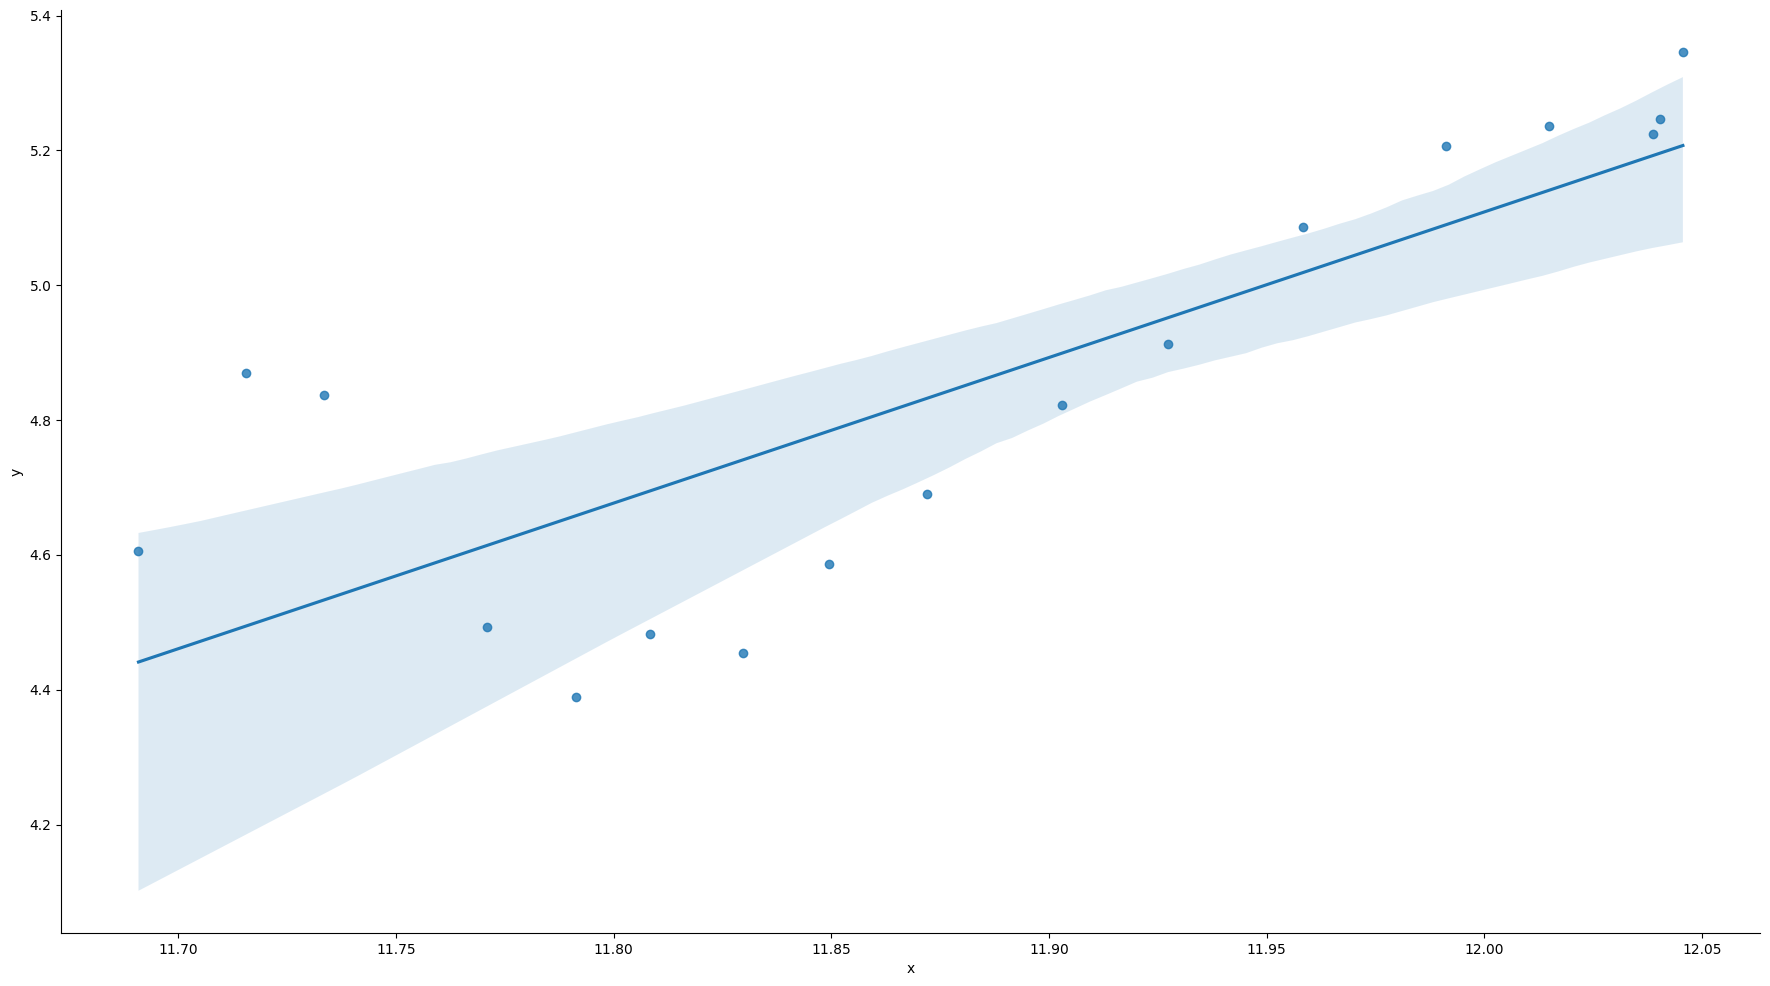

In [201]:
_ = sns.pairplot(
    x_vars=["x"],
    y_vars=["y"],
    data=area_df,
    kind="reg",
    diag_kind="kde",
    size=10,
    aspect=1.8,
)

In [135]:
# First fit the model cross-sectionally, say at T0 and Tn (first and last year in your time series)

# For every area in the country, use 2022 as Tn and 2010 as T0
# Create a dataframe from df where each area code has one row with Yn and Y0 and xn and x0

t0 = 2010
tn = 2022
x = "population"
y = f"{investment_asset_type}_{metric}"

new_df = df.groupby("area_code").apply(lambda area: pd.Series({
    "y0": area.loc[area["year"] == t0, y].values[0],
    "yn": area.loc[area["year"] == tn, y].values[0],
    "x0": area.loc[area["year"] == t0, x].values[0],
    "xn": area.loc[area["year"] == tn, x].values[0],
})).reset_index()

new_df = new_df.dropna()
new_df["yn"] = np.log(new_df["yn"])
new_df["y0"] = np.log(new_df["y0"])
# new_df["x"] = np.log(new_df["xn"])
new_df["x"] = np.log(new_df["xn"] / new_df["x0"])

model = sm.OLS(new_df["yn"], sm.add_constant(new_df[["x", "y0"]])).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     yn   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     242.6
Date:                Sat, 14 Sep 2024   Prob (F-statistic):           4.27e-88
Time:                        18:28:42   Log-Likelihood:                -338.15
No. Observations:                1111   AIC:                             682.3
Df Residuals:                    1108   BIC:                             697.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2502      0.172     13.053      0.000       1.912       2.588
x              3.0764      0.178     17.328      0.000       2.728       3.425
y0             0.4858      0.038     12.793      0.000       0.411       0.560
==============================================================================
Omnibus:                       54.663   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.159
Skew:                           0.086   Prob(JB):                     3.39e-39
Kurtosis:                       4.949   Cond. No.                         86.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

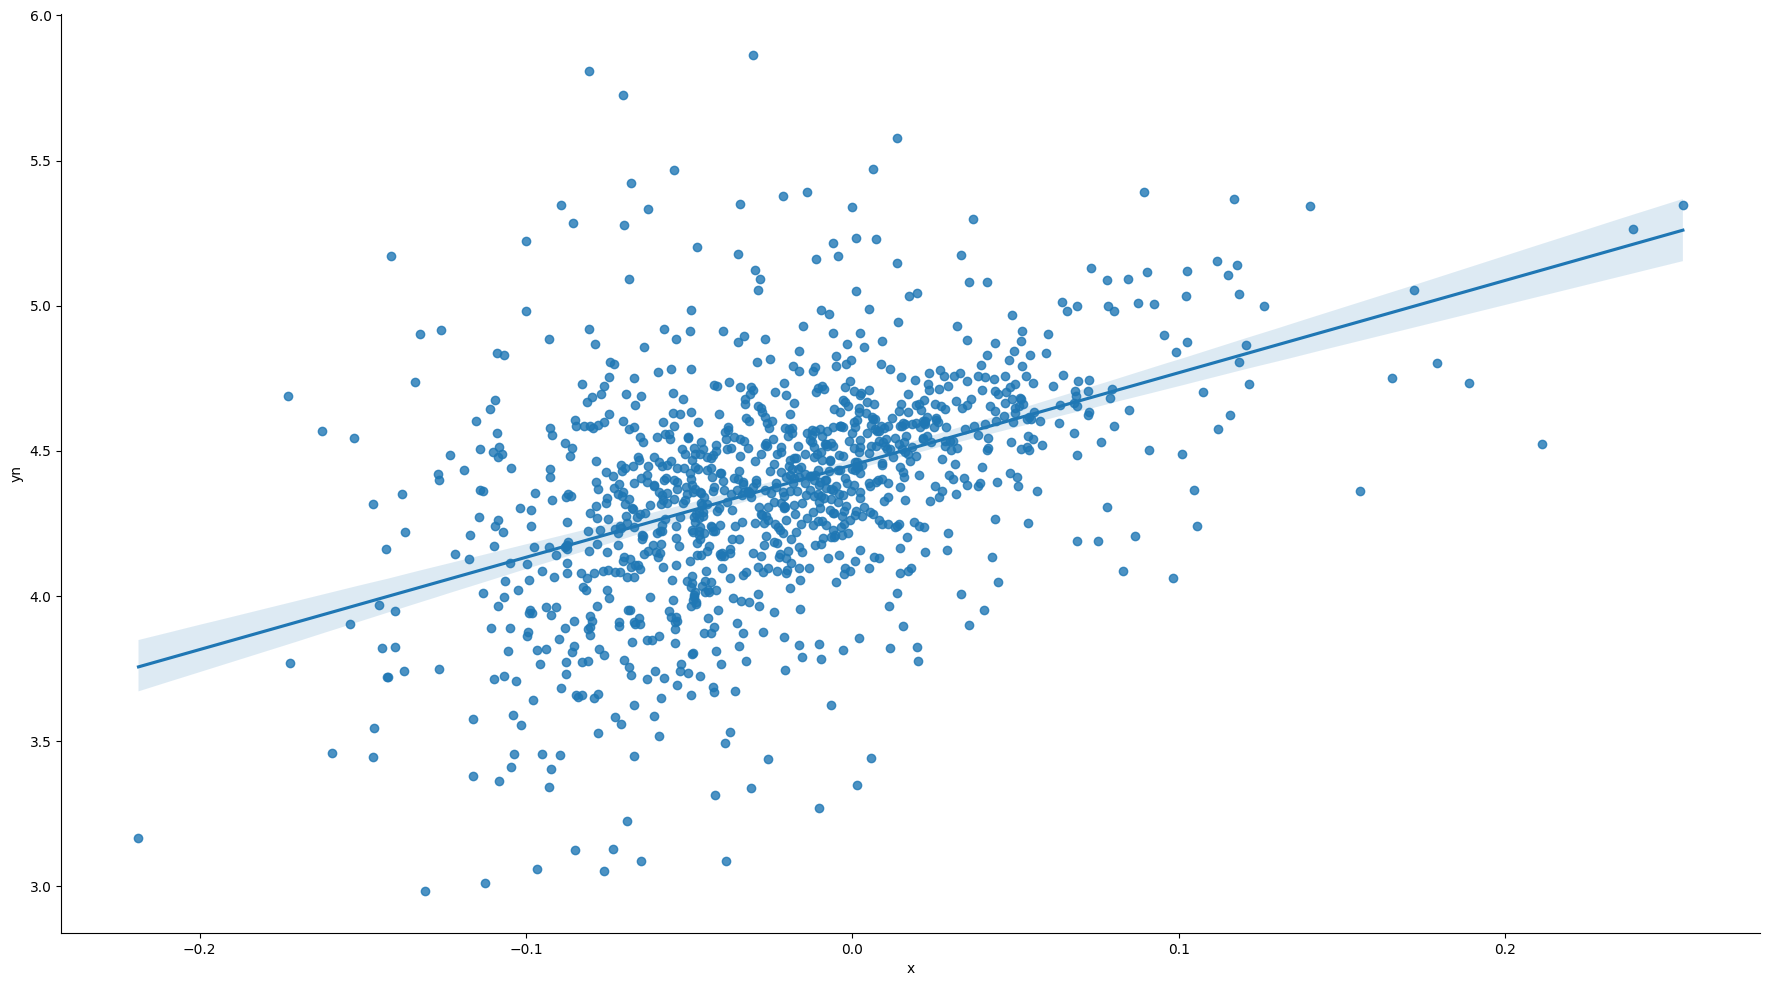

In [136]:
_ = sns.pairplot(
    x_vars=["x"],
    y_vars=["yn"],
    data=new_df,
    kind="reg",
    diag_kind="kde",
    size=10,
    aspect=1.8,
)

In [162]:
# Second fit with your compete time series data

t0 = 2010
x = "population"
y = f"{investment_asset_type}_{metric}"

# For every area in the country, use 2010 as T0
# for every_area in df, for each row, add a column Y0 and x0

base_df = df.groupby("area_code").apply(lambda area: pd.Series({
    "y0": area.loc[area["year"] == t0, y].values[0],
    "x0": area.loc[area["year"] == t0, x].values[0],
})).reset_index()


new_df = df.merge(base_df, on="area_code")
new_df = new_df[new_df["year"] >= t0 + 1].reset_index(drop=True)
new_df = new_df[~new_df[x].isna()].reset_index(drop=True)
new_df = new_df[~new_df[y].isna()].reset_index(drop=True)

new_df["y"] = np.log(new_df[y])
new_df["y0"] = np.log(new_df["y0"])
new_df["x"] = np.log(new_df[x] / new_df["x0"])

model = sm.OLS(new_df["y"], sm.add_constant(new_df[["x", "y0"]])).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     2423.
Date:                Sat, 14 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:16:03   Log-Likelihood:                -2339.2
No. Observations:               13332   AIC:                             4684.
Df Residuals:                   13329   BIC:                             4707.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0155      0.044     46.162      0.000       1.930       2.101
x              2.7467      0.069     40.034      0.000       2.612       2.881
y0             0.5321      0.010     55.305      0.000       0.513       0.551
==============================================================================
Omnibus:                     1231.293   Durbin-Watson:                   0.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8709.583
Skew:                           0.093   Prob(JB):                         0.00
Kurtosis:                       6.955   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

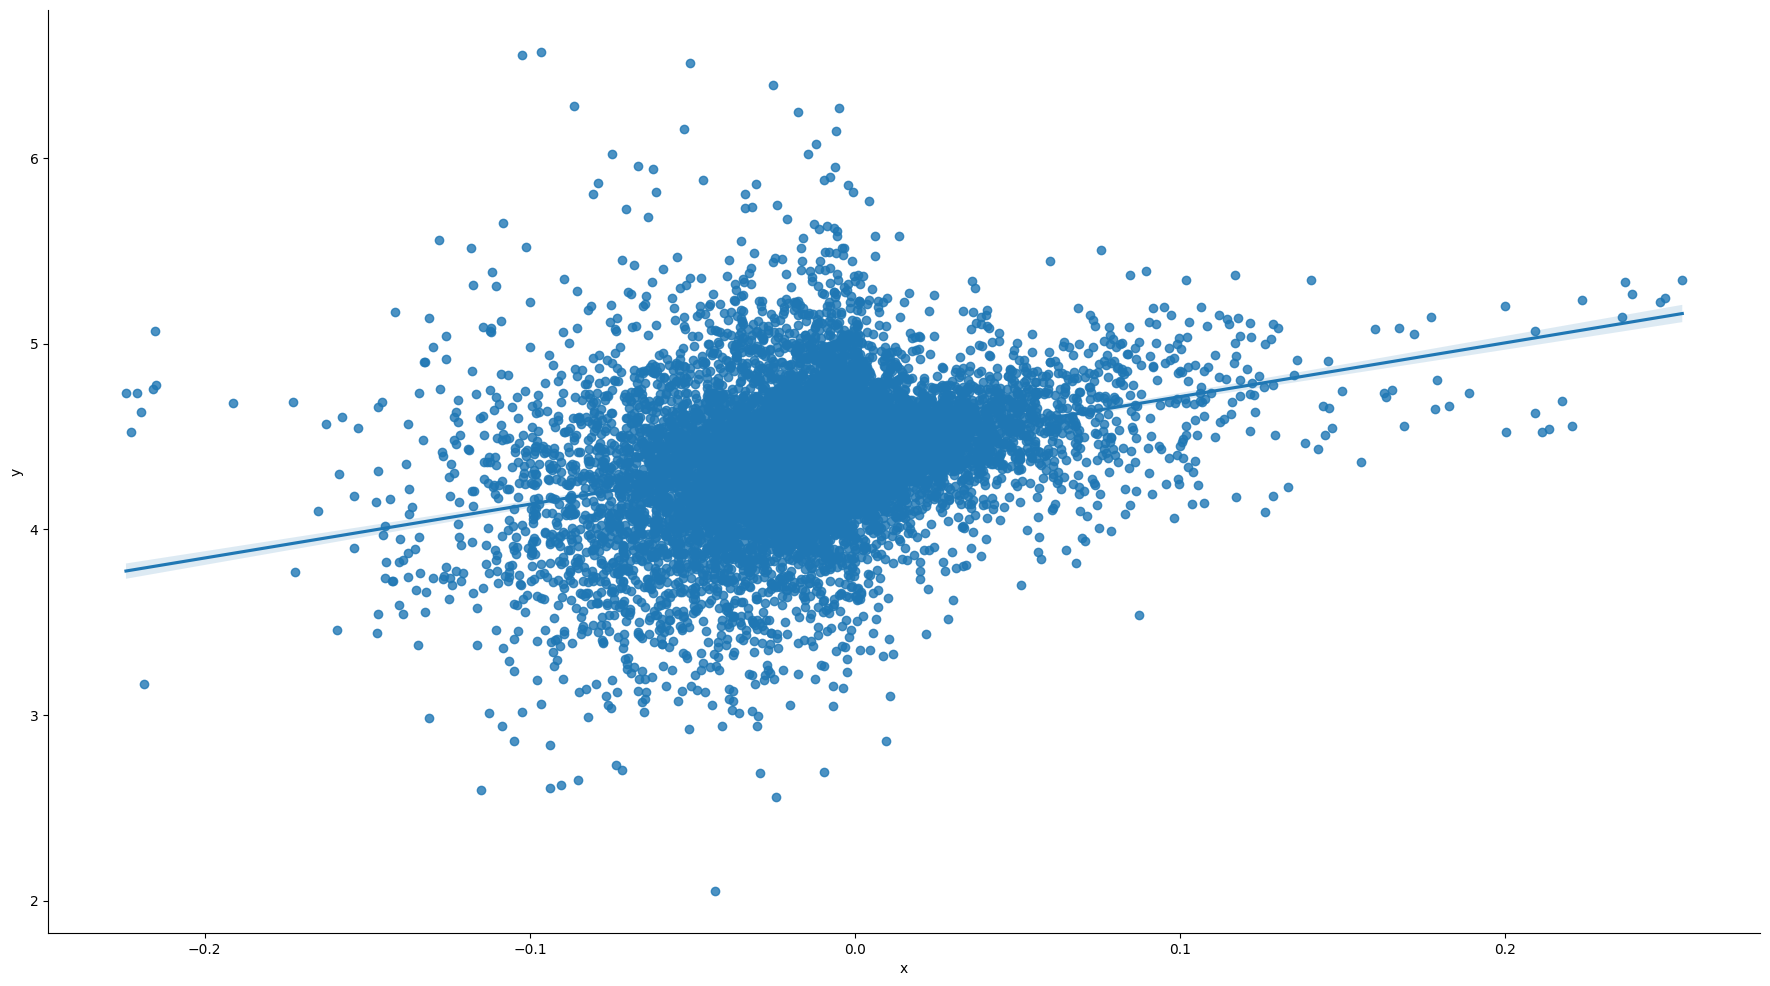

In [163]:
_ = sns.pairplot(
    x_vars=["x"],
    y_vars=["y"],
    data=new_df,
    kind="reg",
    diag_kind="kde",
    size=10,
    aspect=1.8,
)

In [181]:
# Third, fit either cross-sectional or time-series, for different types of cities. For example, classifying your cities into quintiles based on GDP.

# Create quintiles based on taxable_income
base_year_df = df[df["year"] == 2010]
base_year_df["taxable_income_quintile"] = pd.qcut(base_year_df["taxable_income"], 5, labels=False)
area_codes_by_gdp_quintile = [base_year_df[base_year_df["taxable_income_quintile"] == i]["area_code"].unique() for i in range(5)]
quintiles = [df[df["area_code"].isin(area_codes)] for area_codes in area_codes_by_gdp_quintile]


# # Group by taxable_income_quintile and area_code, and then fit the model
# grouped = df.groupby(['taxable_income_quintile', 'area_code'])

# for name, group in grouped:
#     print(name)
#     print(group)
    

In [183]:
quintiles[4]

,area_code,year,building_ols_price_index,population,taxable_income,existing_dwellings,taxable_income_quintile
45,23212,2008,100.000000,183797.323796,332285900.0,60883.0,4
46,23212,2009,83.287145,184914.399183,332805502.0,63048.0,4
47,23212,2010,88.732299,185771.000000,289469234.0,64318.0,4
48,23212,2011,93.227236,186148.000000,301230064.0,65414.0,4
49,23212,2012,94.878533,186527.000000,304933402.0,66649.0,4
...,...,...,...,...,...,...,...
19030,16201,2007,NaN,417406.000000,628131323.0,157150.0,4
19213,35202,2007,NaN,169459.000000,242193727.0,74651.0,4
19214,35203,2007,NaN,194871.000000,266899860.0,NaN,4
19266,28206,2007,NaN,92697.000000,259307366.0,41057.0,4


In [188]:
# Second fit with your compete time series data
quintile = 1

t0 = 2010
x = "population"
y = f"{investment_asset_type}_{metric}"

# For every area in the country, use 2010 as T0
# for every_area in df, for each row, add a column Y0 and x0
quintile_df = quintiles[quintile]
base_df = quintile_df.groupby("area_code").apply(lambda area: pd.Series({
    "y0": area.loc[area["year"] == t0, y].values[0],
    "x0": area.loc[area["year"] == t0, x].values[0],
})).reset_index()


new_df = quintile_df.merge(base_df, on="area_code")
new_df = new_df[new_df["year"] >= t0 + 1].reset_index(drop=True)
new_df = new_df[~new_df[x].isna()].reset_index(drop=True)
new_df = new_df[~new_df[y].isna()].reset_index(drop=True)

new_df["y"] = np.log(new_df[y])
new_df["y0"] = np.log(new_df["y0"])
new_df["x"] = np.log(new_df[x] / new_df["x0"])

model = sm.OLS(new_df["y"], sm.add_constant(new_df[["x", "y0"]])).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     865.9
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          8.20e-293
Time:                        19:24:13   Log-Likelihood:                 1687.9
No. Observations:                2772   AIC:                            -3370.
Df Residuals:                    2769   BIC:                            -3352.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8958      0.164     11.576      0.000       1.575       2.217
x              3.6417      0.095     38.270      0.000       3.455       3.828
y0             0.5617      0.036     15.499      0.000       0.491       0.633
==============================================================================
Omnibus:                      239.006   Durbin-Watson:                   0.453
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              983.092
Skew:                           0.333   Prob(JB):                    3.34e-214
Kurtosis:                       5.840   Cond. No.                         310.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [189]:
quintile_df

,area_code,year,building_ols_price_index,population,taxable_income,existing_dwellings,taxable_income_quintile
45,23212,2008,100.000000,183797.323796,332285900.0,60883.0,4
46,23212,2009,83.287145,184914.399183,332805502.0,63048.0,4
47,23212,2010,88.732299,185771.000000,289469234.0,64318.0,4
48,23212,2011,93.227236,186148.000000,301230064.0,65414.0,4
49,23212,2012,94.878533,186527.000000,304933402.0,66649.0,4
...,...,...,...,...,...,...,...
19030,16201,2007,NaN,417406.000000,628131323.0,157150.0,4
19213,35202,2007,NaN,169459.000000,242193727.0,74651.0,4
19214,35203,2007,NaN,194871.000000,266899860.0,NaN,4
19266,28206,2007,NaN,92697.000000,259307366.0,41057.0,4


In [168]:
df

,area_code,year,building_ols_price_index,population,taxable_income,existing_dwellings,taxable_income_quintile
0,23441,2008,100.000000,25136.592636,41348658.0,NaN,2
1,23441,2009,77.351727,25374.112910,40698843.0,NaN,2
2,23441,2010,85.372440,25695.000000,37069636.0,NaN,1
3,23441,2011,75.213546,26248.000000,37957523.0,NaN,2
4,23441,2012,77.844830,26793.000000,39195622.0,NaN,2
...,...,...,...,...,...,...,...
19263,19424,2021,NaN,9254.000000,22848415.0,NaN,1
19265,19384,2007,NaN,20361.000000,26513666.0,NaN,1
19266,28206,2007,NaN,92697.000000,259307366.0,41057.0,4
19267,47211,2007,NaN,145554.000000,111372337.0,45992.0,3


In [174]:
quintiles[4]

,area_code,year,building_ols_price_index,population,taxable_income,existing_dwellings,taxable_income_quintile
45,23212,2008,100.000000,183797.323796,332285900.0,60883.0,4
46,23212,2009,83.287145,184914.399183,332805502.0,63048.0,4
47,23212,2010,88.732299,185771.000000,289469234.0,64318.0,4
48,23212,2011,93.227236,186148.000000,301230064.0,65414.0,4
49,23212,2012,94.878533,186527.000000,304933402.0,66649.0,4
...,...,...,...,...,...,...,...
19030,16201,2007,NaN,417406.000000,628131323.0,157150.0,4
19213,35202,2007,NaN,169459.000000,242193727.0,74651.0,4
19214,35203,2007,NaN,194871.000000,266899860.0,NaN,4
19266,28206,2007,NaN,92697.000000,259307366.0,41057.0,4
